# Analysis:

1) There are huge variations in charges for the SAME treatment across hospitals. Some hospitals can charge up to 8x as much as the median charge for for the same treatment.
2) The highest costing hospitals are centered around densely populated states and cities. There are also very few hospitals in our dataset in the mid-west region of the United States. (See "Avg Cost by Hospitals in US")
3) Early analysis of income, population density, and hospital size does not reveal as much about costs as Hospital Ownership (See "Linda's Scatter Plot -- Ownership vs Cost"). Therefore we performed further analysis on the impact of Hospital Ownership (Government, Non-Profit, and Individual Business).
4) Non-profit Hospitals tend to be the highest rated, the largest, and only slightly more expensive than Government or Individual Business hospitals. (See "Overall Comparison")
5) Though averages tell one story, looking at the histograms for distribution reveals that Non-profits and Individual businesses can have a larger variation in charges than Government Hospitals. See "Distribution of Cost by Types"
6) There is a significant difference between Hospital Charges and Medicare Payment Costs. If you do not have insurance, you risk paying the full hospital charge!

### 1) Creating Main Data Set for Analysis

In [29]:
#Import dependencies and raw data files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import ipywidgets as widgets
from IPython.display import display
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool,PanTool,WheelZoomTool,BoxZoomTool,ResetTool,UndoTool,RedoTool, Range1d
# import plotly as py
import plotly as py
import plotly.tools as tls
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import folium
# from config import gkey


py.offline.init_notebook_mode(connected=True)


#Read raw data sets
data1 = pd.read_csv("Inpatient_Prospective_Payment_System.csv",encoding='mac_roman') #core raw data set
data2 = pd.read_csv("bedsLatLong.csv",encoding='mac_roman') #grabbing bed count only
data3 = pd.read_csv("ratingsAndOwnership.csv",encoding='mac_roman') #grabbing ratings and ownership type only


In [30]:
#Core data set, grabbing keys of interest
data1 = data1[['Provider Id', 'Provider Name', 'Provider Street Address', 
               'Provider City', 'Provider State', 'Provider Zip Code',     
               ' Average Total Payments ', 'Average Medicare Payments', ' Average Covered Charges ']]

#Beds data set, grabbing keys of interest
data2 = data2[[ 'ID', 'NAME',  'BEDS']]
data2 = data2.rename(columns={'ID': 'Provider Id', 'NAME':'Provider Name'})

#Ratings and Ownership dataset, grabbing keys of interest
data3 = data3[['Provider ID', 'Hospital Type', 'Hospital Ownership',
       'Hospital overall rating']]
data3 = data3.rename(columns={'Provider ID': 'Provider Id'})


In [31]:
#Merging datasets by Provider Id and Provider Name
main = pd.merge(data1,data3, on = 'Provider Id', how = 'outer')
main = pd.merge(main,data2, on = 'Provider Name', how = 'outer')

In [32]:
#Removing duplicate keys for Provider Id and renaming
main = main[['Provider Id_x', 'Provider Name', 'Provider Street Address',
       'Provider City', 'Provider State', 'Provider Zip Code',
        ' Average Covered Charges ',' Average Total Payments ', 
        'Average Medicare Payments','Hospital Type', 'Hospital Ownership', 
        'Hospital overall rating', 'BEDS']]
main = main.rename(columns={'Provider Id_x': 'Provider Id'})

In [33]:
#grouping catagory into Hospital ownership: Voluntary(non-profit), Government, Individual business
main["Hospital Ownership"] = main["Hospital Ownership"].replace({
    
    'Voluntary non-profit - Private':'Voluntary(non-profit)',
    'Voluntary non-profit - Church':'Voluntary(non-profit)',
    'Voluntary non-profit - Other':'Voluntary(non-profit)', 
    
    'Government - Hospital District or Authority': 'Government',
    'Government - State': 'Government',
    'Government - Local': 'Government',
    'Government - Federal': 'Government',
    
    'Proprietary': 'Individual Business',
     'Physician': 'Individual Business'})

In [34]:
#Cleaning by droping redundant rows and rows with empty fields
main= main.drop_duplicates()
main = main.dropna(how = "any") 
main = main[main['Hospital overall rating'] != "Not Available"]
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122360 entries, 0 to 184196
Data columns (total 13 columns):
Provider Id                  122360 non-null float64
Provider Name                122360 non-null object
Provider Street Address      122360 non-null object
Provider City                122360 non-null object
Provider State               122360 non-null object
Provider Zip Code            122360 non-null float64
 Average Covered Charges     122360 non-null object
 Average Total Payments      122360 non-null object
Average Medicare Payments    122360 non-null object
Hospital Type                122360 non-null object
Hospital Ownership           122360 non-null object
Hospital overall rating      122360 non-null object
BEDS                         122360 non-null float64
dtypes: float64(3), object(10)
memory usage: 13.1+ MB


In [35]:
#Converting payment strings to floats
main[' Average Total Payments '] = main[' Average Total Payments '].str.split('$').apply(lambda x: x[-1])
main['Average Medicare Payments'] = main['Average Medicare Payments'].str.split('$').apply(lambda x: x[-1])
main[' Average Covered Charges '] = main[' Average Covered Charges '].str.split('$').apply(lambda x: x[-1])
main[' Average Total Payments '] = pd.to_numeric(main[' Average Total Payments '])
main['Average Medicare Payments'] = pd.to_numeric(main['Average Medicare Payments'])
main[' Average Covered Charges '] = pd.to_numeric(main[' Average Covered Charges '])
main['Hospital overall rating'] = pd.to_numeric(main['Hospital overall rating'])

main['Provider Id'] = main['Provider Id'].astype(np.int64)


In [36]:
#Adding a new "Cost" key
main['Cost'] = main[' Average Total Payments '] - main['Average Medicare Payments']

In [37]:
#Main Dataframe
print(main.shape)
main.to_csv("main_data.csv")
main.head(3)

(122360, 14)


,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Average Covered Charges,Average Total Payments,Average Medicare Payments,Hospital Type,Hospital Ownership,Hospital overall rating,BEDS,Cost
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,32963.07,5777.24,4763.73,Acute Care Hospitals,Government,3,420.0,1013.51
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,20312.78,4894.76,3865.50,Acute Care Hospitals,Government,3,420.0,1029.26
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,38820.39,10260.21,9167.08,Acute Care Hospitals,Government,3,420.0,1093.13


### Create dataset that averages all charges by each Hospital

In [38]:
#Create subset of keys
main_less = main.drop([' Average Covered Charges ', ' Average Total Payments ', 'Average Medicare Payments', 'Cost', 'Provider Zip Code', 'BEDS', 'Hospital overall rating'], axis=1)

In [39]:
#Group all providers to average all charges/costs irrespective of treatment charges
main_mean = main.groupby('Provider Id').mean()
main_mean = pd.DataFrame(main_mean).reset_index(inplace=False)
#Merge averaged costs with 'main_data' and drop all duplicates
main_mean = main_mean.merge(main_less, on='Provider Id', how='inner', copy=False)
print(len(main_mean))
main_mean = main_mean.drop_duplicates(keep = 'first').reset_index(inplace=False)
main_mean = main_mean.drop(['index'], axis=1)
print(len(main_mean))

122360
1983


### Perform Google API: Geocode search to populate latitude and longitude for each hospital
##### Do not uncomment unless you want to re-run API calls

In [40]:
# #Join address and city and state
# address = []

# def get_address(index):
#     target = main_mean['Provider Street Address'][index] + ", " + main_mean['Provider City'][index] + ", " + main_mean['Provider State'][index]
#     return target
# for i in range(len(main_mean)):
#     address.append(get_address(i))

In [41]:
# lat = []
# lng = []
# counter = 0

# #Return json response
# for target_address in address:
#     params = {"address": target_address, "key": gkey}
#     base_url = "https://maps.googleapis.com/maps/api/geocode/json"
#     response = requests.get(base_url, params=params).json()
#     #traverse response to find lon/lat
#     try:
#         lat.append(response['results'][0]['geometry']['location']['lat'])
#         lng.append(response['results'][0]['geometry']['location']['lng'])
#     except Exception:
#         lat.append(0)
#         lng.append(0)
#     counter = counter + 1
#     print(f'{counter} of {len(main_mean)} completed')


In [42]:
# #Add new values to main_mean
# main_mean['Location'] = address
# main_mean['Latitude'] = lat
# main_mean['Longitude'] = lng
# main_mean = main_mean[main_mean['Longitude'] != 0]
# main_mean.to_csv('main_mean.csv')
# print(len(main_mean))
# main_mean.head(2)

In [43]:
main_mean = pd.read_csv('main_mean.csv')

### Harry's USA Map: Avg Cost by Hospitals in US

In [44]:
#input into plotly by scattergeo
data = [dict(type="scattergeo", locationmode="USA-states", text = main_mean['Provider Name'] + main_mean['Provider Street Address'], lon = main_mean['Longitude'], lat = main_mean['Latitude'], 
             marker = dict(size=4, autocolorscale=False, colorscale='Portland',
            color = main_mean[' Average Covered Charges '], colorbar = dict(title = 'Avg Cost ($)')))]

In [45]:
layout = dict(title="Avg Cost by Hospitals in US",
              geo = dict(scope='usa',projection = dict(type='albers usa'), 
                         showland=True, landcolor="rgb(250,250,250)"))

In [46]:
fig = dict(data=data, layout=layout)
py.plotly.image.save_as(fig,filename='USA_map_avg_cost.png')
py.plotly.iplot(fig)


### Starting Nami's App for State analysis

In [47]:
def checkDF(df):
    requirements = ['Provider State', 'Cost', 'BEDS', 'Provider Name']
    errorFlag = False
    for req in requirements:
        if not req in df:
            print(f'DF structure error: dataframe must include "{req}". please confirm your dataframe:-(')
            errorFlag = True
            break
    if not errorFlag:
        print('Checks out!')
        return df

In [48]:
df = checkDF(main_mean)
df.columns

Checks out!


Index(['Unnamed: 0', 'Provider Id', 'Provider Zip Code',
       ' Average Covered Charges ', ' Average Total Payments ',
       'Average Medicare Payments', 'Hospital overall rating', 'BEDS', 'Cost',
       'Provider Name', 'Provider Street Address', 'Provider City',
       'Provider State', 'Hospital Type', 'Hospital Ownership', 'Location',
       'Latitude', 'Longitude'],
      dtype='object')

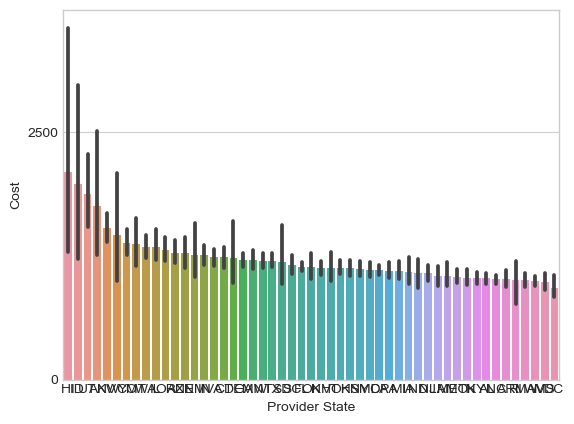

In [49]:
states = df.groupby('Provider State').mean().sort_values(by=['Cost'], ascending=False).index
sns.barplot(x='Provider State', y='Cost', data=df, order=states)
sns.set(rc={'figure.figsize':(100,75)}, font_scale=7)
plt.savefig('state_cost.png')
plt.show()

### Pierre's Bar Chart: State and Ratings

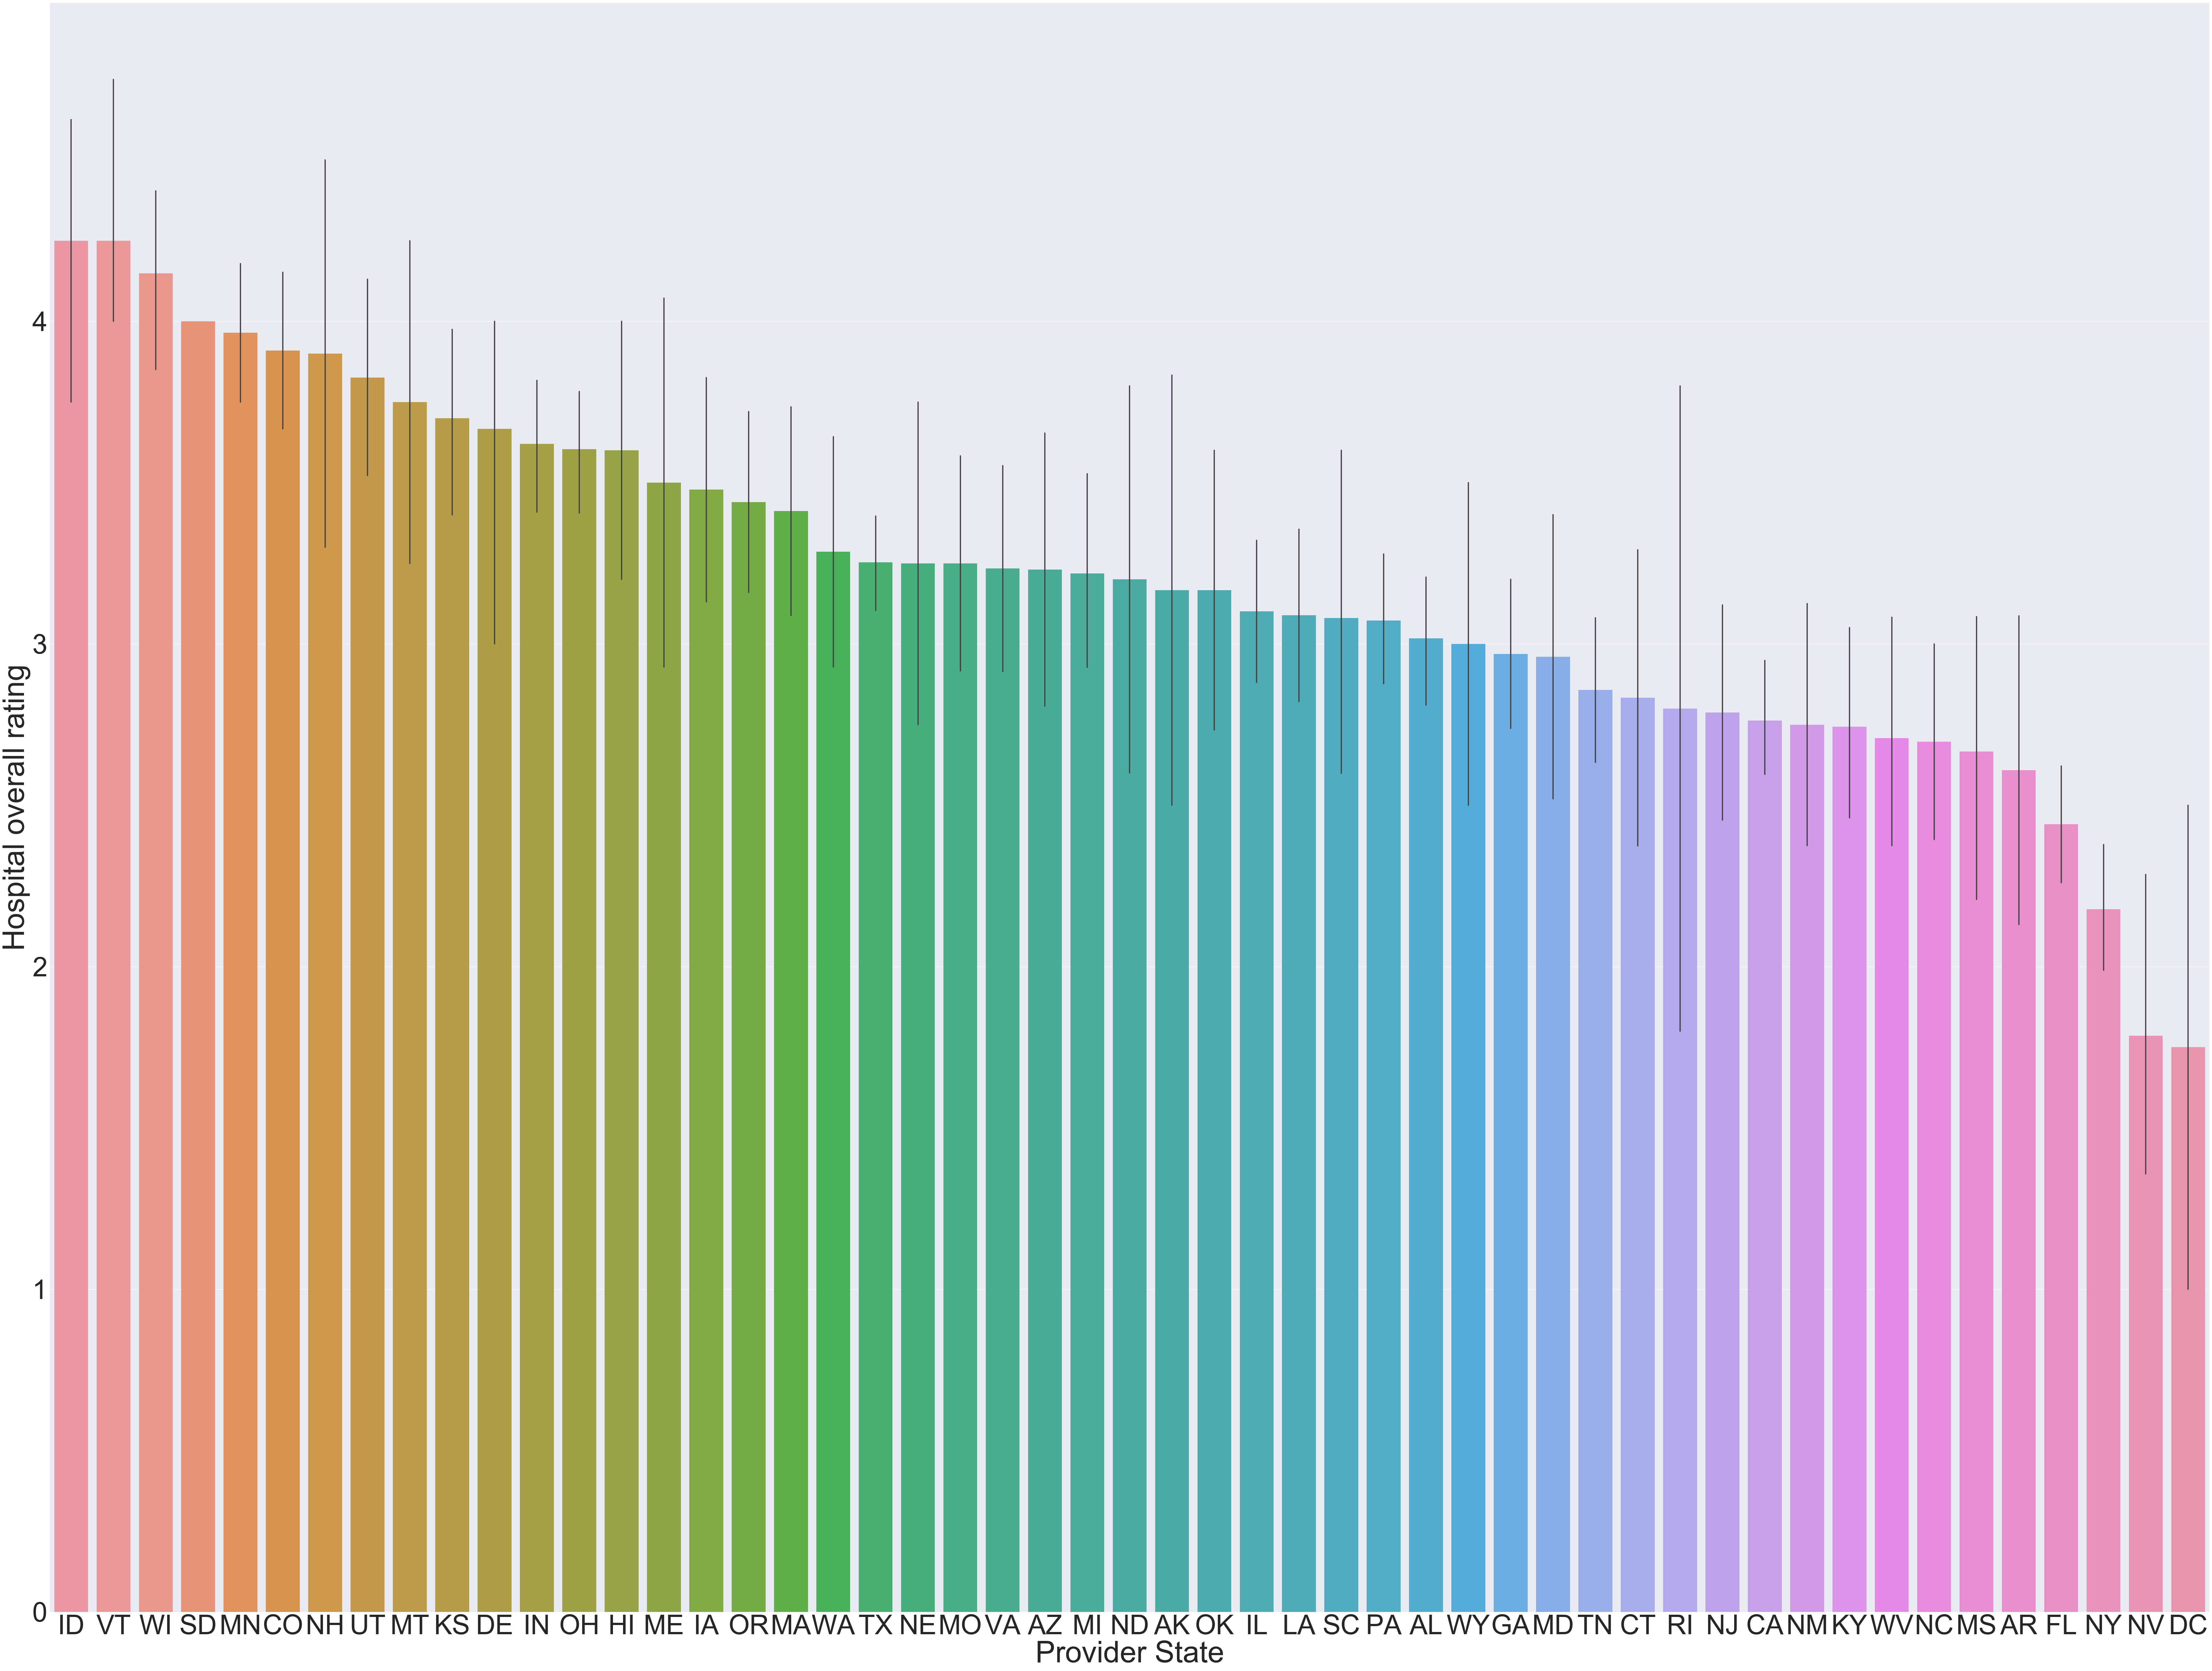

In [50]:
states = df.groupby('Provider State').mean().sort_values(by=['Hospital overall rating'], ascending=False).index
sns.barplot(x='Provider State', y='Hospital overall rating', data=df, order=states)
sns.set(rc={'figure.figsize':(100,75)}, font_scale=7)
plt.savefig('state_rating.png')
plt.show()

In [51]:
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
state_geo = 'us-states.json'
 
df2 = df[df['BEDS']>0]

# Load the values of each state
state_data = pd.DataFrame()
state_data['State'] = list(df2.groupby('Provider State').mean().index)
state_data['Cost'] = list(df2.groupby('Provider State').mean()['Cost'])
state_data['HospitalCounts'] = list(df2.groupby('Provider State').count()['Cost'])
state_data['Rating'] = list(df2.groupby('Provider State').mean()['Hospital overall rating'])
state_data['BedCounts'] = list(df2.groupby('Provider State').mean()['BEDS'])
# state_data
# threshold_scale = split_six(state_data['Cost'])
colors = ['#1a9850', '#91cf60', '#fc8d59', '#d9ef8b', '#ffffbf','#fee08b']



In [52]:
### Choropleth US Map for Hospital Costs
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)
# step = folium.StepColormap(colors, vmin=921, vmax=2022, index=[921, 1105, 1288, 1472, 1655,1838,2022])
# step = folium.StepColormap(colors)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['State', 'Cost'],
 key_on='feature.id',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Cost ($)'
)
folium.LayerControl().add_to(m)

m

In [82]:
### Choropleth US Map for Hospital Count
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['State', 'HospitalCounts'],
 key_on='feature.id',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Hospital Count'
)
folium.LayerControl().add_to(m)

m

In [54]:
### Choropleth US Map for Hospital Ratings

# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['State', 'Rating'],
 key_on='feature.id',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Rating'
)
folium.LayerControl().add_to(m)

m

In [55]:
### Chloropleth US Map for Hospital Size

# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['State', 'BedCounts'],
 key_on='feature.id',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Hospital Size'
)
folium.LayerControl().add_to(m)

m

In [56]:
def showPlot(df, state, rating=[1,2,3,4,5]):
    if not state in list(df['Provider State']):
        print('your state input might be wrong. please check your input!')
    elif not isinstance(rating, list) or len(rating)==0:
        print('rating must be a list contains more than one numeric element. please check your input!')
    else:
        dfbyState = df[df['Provider State'] == state]
        #dfbyState_Rating = dfbyState[dfbyState["Hospital overall rating"].isin(rating)]
        sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=dfbyState, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.9})
        sns.set(rc={'figure.figsize':(2,1)}, font_scale=1)
        plt.ylim(0,)
        plt.xlim(0,4000)
        plt.title(f'Cost-Size relationship in {state}')
#         plt.savefig(f'cost_size_rating_in{state}.png')
        plt.show()

In [57]:

plt.rcParams.update(plt.rcParamsDefault)
def f(STATE):
    showPlot(df,STATE)
states = df.groupby('Provider State').mean().index
widgets.interact(f, STATE=states);

A Jupyter Widget

In [58]:
hover = HoverTool(tooltips=[
    ("name:", "@prov"),
    ("cost:", "$x"),
    ("size:", "$y")    
])
pan = PanTool()
box = BoxZoomTool()
undo = UndoTool() 
redo = RedoTool()
reset = ResetTool()

# drop data that 'BEDS' > 0
df_hasbeds = df[df['BEDS'] > 0]
states = df_hasbeds.groupby('Provider State').mean().index
d = widgets.Dropdown(options=states, value='AK')
exg_r = []

def initialize_source():
    return ColumnDataSource(data=dict(x=[],y=[],prov=[]))

def initialize_figure(title='Cost-Size relationship', tools=[hover,box,pan,undo,redo,reset], plot_width=640, plot_height=400):
        fig = figure(title=title, tools=tools, plot_width=plot_width, plot_height=plot_height)
        x = np.array([])
        y = np.array([])
        fig.scatter(x, y)     
        return fig
        
# Event handler
def on_value_change(change):
    print('on_val_ch: ' + str(len(exg_r)))
    for r in exg_r:
        if r.visible:
            r.visible=False
    
#     r = fig.line("x", "y", source=initialize_source(), legend=change.new)
#     r.visible=False
#     print(change.new)
    new_dfbyState = df_hasbeds[df_hasbeds['Provider State'] == change.new]
    overlayPlot(new_dfbyState, change.new, [np.random.randint(1,3)])
#     for i in [1,2,3,4,5]:
#         df_State_Rating = new_dfbyState[new_dfbyState["Hospital overall rating"].isin([i])]
#         x = df_State_Rating['Cost']
#         y = df_State_Rating['BEDS']
#         provider = df_State_Rating['Provider name']
#         source = ColumnDataSource(data=dict(x=x,y=y,prov=provider))
#         r = fig.scatter("x", "y", source=source, color = colors[i-1], legend=str(i))
#         push_notebook(handle=t)
#     print(new_dfbyState)
#     new_dfbyState_Rating = new_dfbyState[new_dfbyState["Hospital overall rating"].isin([1,2,3,4,5])]
#     x=new_dfbyState_Rating['Cost']
#     y=new_dfbyState_Rating['BEDS']
#     provider=new_dfbyState_Rating['Provider name'] 
#     source.data=dict(x=x,y=y,desc=provider)
#     t = show(f, notebook_handle=True)
    t = show(fig, notebook_handle=True)
    
    push_notebook(handle=t)
    
def overlayPlot(df_State, state, ratings):
    colors = ['#d7191c', '#fdae61', '#e0e03e', '#a6d96a', '#1a9641']
    if not isinstance(ratings, list) or len(ratings)==0:
        print('rating must be a list contains more than one numeric element. please check your input!')
    else:
        for i in ratings:
            df_State_Rating = df_State[df_State["Hospital overall rating"].isin([i])]
            x = df_State_Rating['Cost']
            y = df_State_Rating['BEDS']
            provider = df_State_Rating['Provider Name']
            source = ColumnDataSource(data=dict(x=x,y=y,prov=provider))
            r = fig.scatter("x", "y", source=source, color = colors[i-1], legend= 'Rating: ' + str(i))
            r.name= f'Rating: {i} --- {state}'
            exg_r.append(r)
    
    for r in exg_r:
        print(f'{r.name}, {r.visible}')   

d.observe(on_value_change, names='value')


target_state = 'CA'
fig = figure(width=640, height=400, tools=[hover,box,pan,undo,redo,reset], title=f'{target_state} Cost-Size relationship')

dfbyState = df_hasbeds[df_hasbeds['Provider State'] == target_state]

display(d)
overlayPlot(dfbyState, target_state,[1,2,3,4,5])
output_notebook()
fig.xaxis.axis_label = 'Cost'
fig.yaxis.axis_label = 'Size (Bed count)'

t = show(fig, notebook_handle=True)

A Jupyter Widget

Rating: 1 --- CA, True
Rating: 2 --- CA, True
Rating: 3 --- CA, True
Rating: 4 --- CA, True
Rating: 5 --- CA, True


Loading BokehJS ...

### Linda's Scatter Plot --- Ownership vs cost

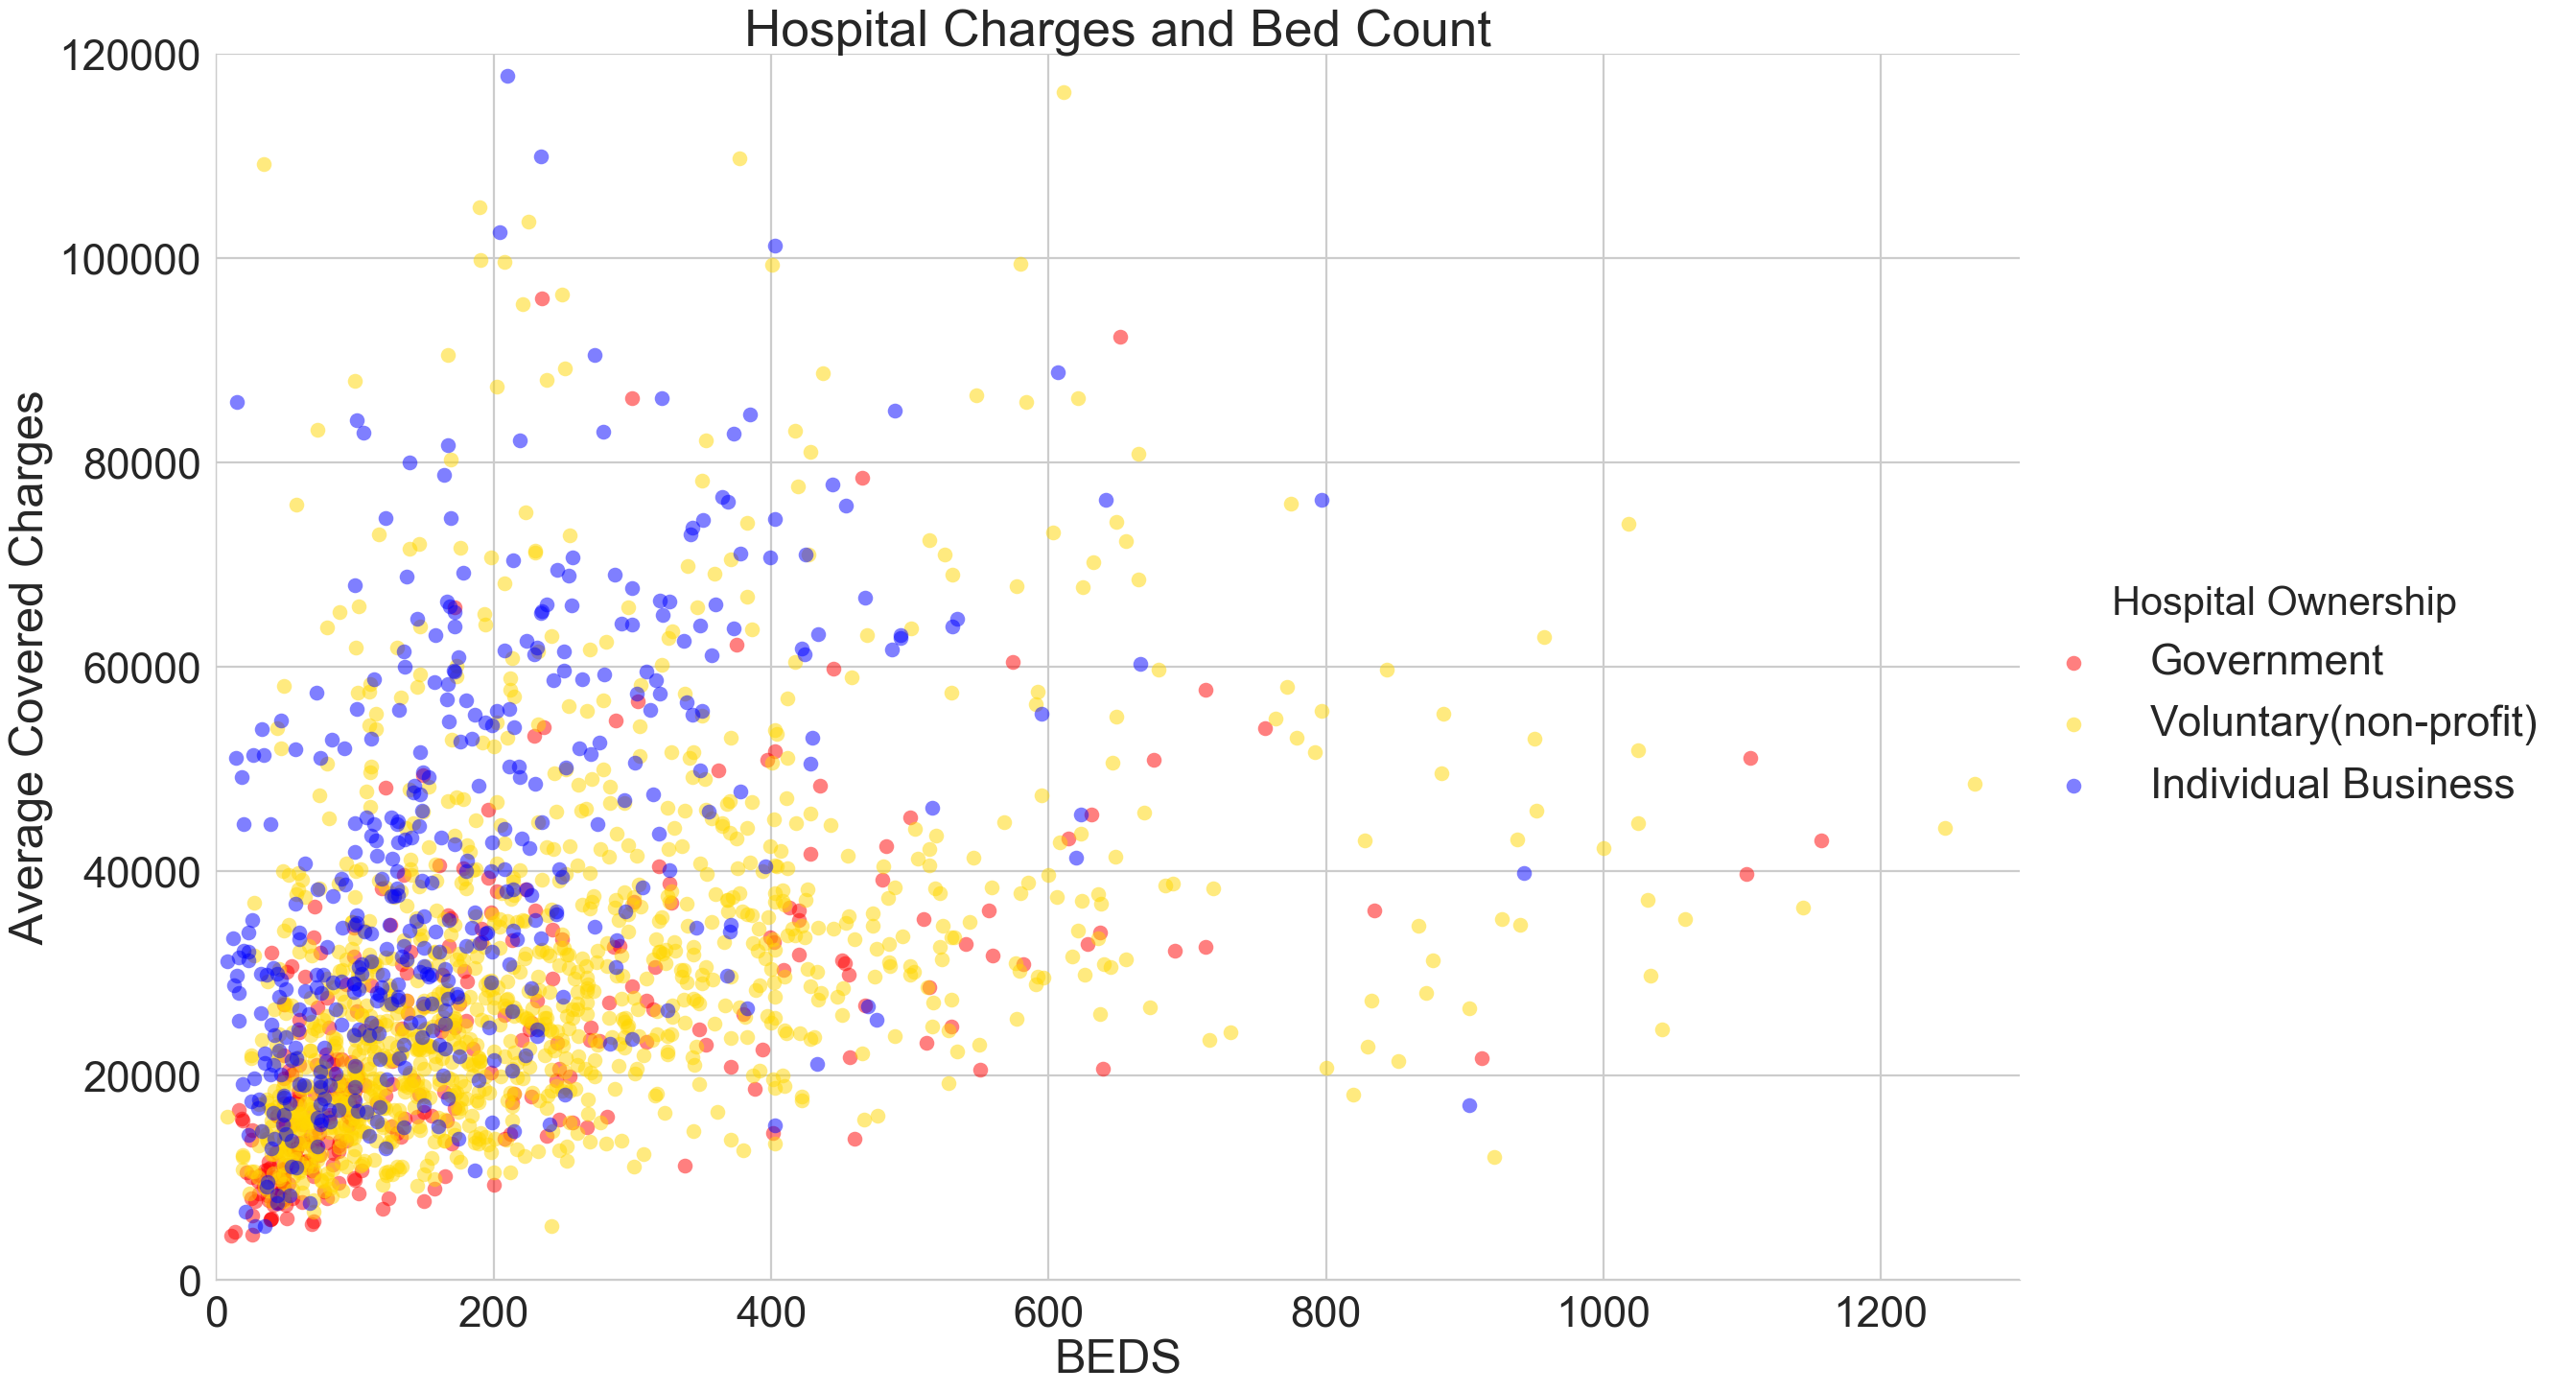

In [94]:

sns.set_context("poster", font_scale = 2)
fig = sns.lmplot(x='BEDS', y=' Average Covered Charges ', hue="Hospital Ownership", data=df, 
           fit_reg=False, scatter_kws={"alpha":0.5},size=15, aspect=1.5, palette=['red','gold','blue'])
plt.xlim(0, 1300)
plt.ylim(0, 120000)
plt.title("Hospital Charges and Bed Count")
plt.figure
plt.savefig("Scatter-Hospital Charges and Bed Count.png")
plt.show()

In [71]:
def make_histogram_owner(owner):
    eval_df = main.loc[(main['Hospital Ownership'] == owner)]
    plt.hist(eval_df[' Average Covered Charges '], bins=bins, alpha=0.4, label=f'{owner} Hospital Charges')
    
def adjusted(owner):
    eval_df = main.loc[(main['Hospital Ownership'] == owner)]
    plt.hist(eval_df[' Average Covered Charges '][0:round(len(eval_df)/int(5))] , bins=bins, alpha=0.4, label=f'{owner} Hospital Charges')

In [70]:
len(main)

122360

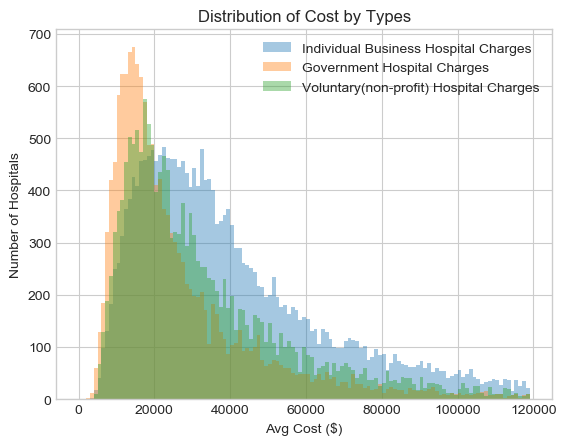

In [81]:
plt.rcParams.update(plt.rcParamsDefault)

bins = np.arange(0,120000, 1000)
sns.set_style('whitegrid')

make_histogram_owner('Individual Business')
make_histogram_owner('Government')
adjusted('Voluntary(non-profit)')

plt.legend(loc='upper right')
plt.title('Distribution of Cost by Types')
plt.ylabel('Number of Hospitals')
plt.xlabel('Avg Cost ($)')
plt.savefig("Distribution of Cost by Types.png")
plt.show()

### Sunny's and Shihong Ownership Analysis

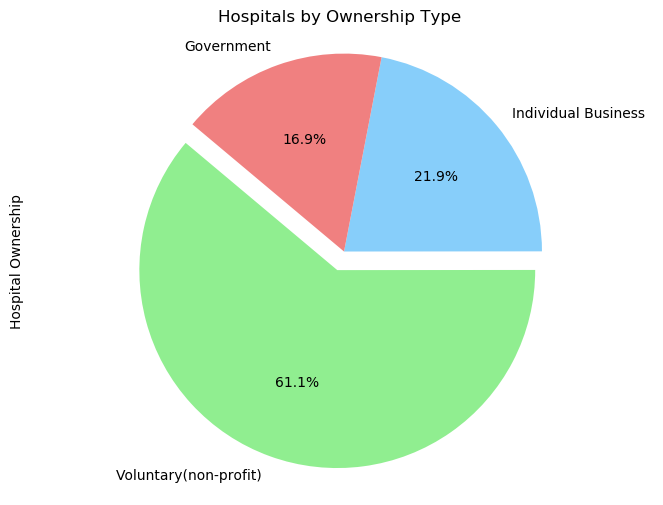

In [77]:
#ploting the percentage of hospitital ownership
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,6))
df["Hospital Ownership"].value_counts(normalize= True).plot(
    kind = "pie",
    explode=[0.1,0,0],
    colors=["lightgreen", "lightskyblue", "lightcoral"],
    autopct="%1.1f%%",
    shadow=False, 
    startangle=140)
plt.title("Hospitals by Ownership Type")
plt.axis("equal") 

plt.savefig("Pie - hospitals by ownership type.png")
plt.show()

In [78]:
#Count for each type of hospital
types = df['Hospital Ownership'].unique()
for each in types:
    print(each)
    print(df['Hospital Ownership'][df['Hospital Ownership'] == each].count())

Government
334
Voluntary(non-profit)
1206
Individual Business
433


In [79]:
# Visualization for cost, rating, capacity for all ownership type 
cost_graph = go.Bar(x =[df['Hospital Ownership'].unique()[0],df['Hospital Ownership'].unique()[2], df['Hospital Ownership'].unique()[1]], 
                    y = df.groupby('Hospital Ownership')['Cost'].mean(),
                   name = "Cost", 
                   marker=dict(
        color='#b2df8a',
        line=dict(
            color='rgb(8,48,107)',
            width=1),
        ))


capa_graph = go.Bar(x =[df['Hospital Ownership'].unique()[0],df['Hospital Ownership'].unique()[2], df['Hospital Ownership'].unique()[1]], 
                    y = df.groupby('Hospital Ownership')['BEDS'].mean(),
                   name = "Capacity",
                   marker=dict(
        color='#a6cee3',
        line=dict(
            color='rgb(8,48,107)',
            width=1),
        ))

rating_graph = go.Bar(x =[df['Hospital Ownership'].unique()[0],df['Hospital Ownership'].unique()[2], df['Hospital Ownership'].unique()[1]], 
                    y = df.groupby('Hospital Ownership')['Hospital overall rating'].mean()*100,
                   name = "Rating",
                   marker=dict(
        color='#1f78b4',
        line=dict(
            color='rgb(8,48,107)',
            width=1),
        ))
data = [cost_graph, capa_graph, rating_graph ]

updatemenus = list([
    dict(type="buttons", x = -0.3,
       
         buttons=list([   
            dict(label = 'Cost Comparison', 
                 method = 'update',  
                 args = [{'visible': [True, False, False]}, 
                         {'title': 'Cost(USD) vs Ownership Type'
                          }]),
            dict(label = 'Capacity Comparison',
                 method = 'update',
                 args = [{'visible': [False, True, False]}, 
                         {'title': 'Capacity(Number of Beds) vs Ownership Type'
                          }]),
            dict(label = 'Rating Comparison',
                 method = 'update', 
                 args = [{'visible': [False, False, True]}, 
                         {'title': 'Rating(Out of 500) vs Ownership Type',
                          }]),
             dict(label = 'Overall Comparison',
                 method = 'update', 
                 args = [{'visible': [True, True, True,True]},  
                         {'title': 'Overall Comparison'
                          }])

       
    
]))])


layout = dict( title ="Overall Comparison", showlegend=True,  width=600,
    height=400,updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
py.plotly.image.save_as(fig,filename='Overall_comparison_types.png')
py.offline.iplot(fig)


In [80]:
#Made this awesome geo scatter plot, WOOOT!
#input into plotly by scattergeo
gov = dict(type="scattergeo", locationmode="USA-states", name = df['Hospital Ownership'].unique()[0],
            text = df['Hospital Ownership'].unique()[0] , 
            lon = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[0], 'Longitude'],
            lat = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[0], 'Latitude'], 
             marker = dict(size=6, autocolorscale=True, colorscale='custom-colorscale',
            color = '#d7191c'))

vol = dict(type="scattergeo", locationmode="USA-states", name = df['Hospital Ownership'].unique()[1],
            text = df['Hospital Ownership'].unique()[1] , 
            lon = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[1],'Longitude'],
            lat = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[1], 'Latitude'], 
             marker = dict(size=6, autocolorscale=True, colorscale='custom-colorscale',
            color = '#fdae61'))

ind = dict(type="scattergeo", locationmode="USA-states", name = df['Hospital Ownership'].unique()[2],
            text = df['Hospital Ownership'].unique()[2] , 
            lon = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[2], 'Longitude'],
            lat = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[2], 'Latitude'], 
             marker = dict(size=6, autocolorscale=True, colorscale='custom-colorscale',
            color = '#2c7bb6'))

data = [gov,vol,ind]

layout = dict(title="Hospital Ownership Distribution in US", showlegend=True,
              geo = dict(scope='usa',projection = dict(type='albers usa'), 
                         showland=True, landcolor="#abd9e9"))

fig = dict(data=data, layout=layout)
py.plotly.image.save_as(fig,filename='USA_map_hospital_types.png')
py.offline.iplot(fig)
